# K-MEANS clustering 

In [1]:
import copy
from os import path

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, AgglomerativeClustering, OPTICS
from sklearn.model_selection import ParameterSampler
import pandas as pd
import numpy as np
import seaborn

from transformations import center_and_scale

# show all elements of a dataframe
# pandas.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)



## Hyperparameter search for K-Means

In [2]:
# since several algorithms are randomized, we set a seed to repeat them
RANDOM_STATE = 42

# load dataset
datasetname = path.join('..','dataset', 'cyclists_final_enhanced.csv')
cyclists=pd.read_csv(datasetname)
numeric_dataset = cyclists.select_dtypes(include="number")
normalized_df, normalization_scalers_df = center_and_scale(numeric_dataset)
cyclists.isna().sum()

_url                      0
name                      0
birth_year                0
weight                    0
height                    0
nationality               0
bmi                       0
career_points             0
career_duration(days)     0
career_duration(races)    0
debut_year                0
avg_pos                   0
dtype: int64

In [3]:
# computing sample densities for DBScan to avoid arbitrary values
# maximum distance between any two points in the dataset
maximum_distance = abs(normalized_df.max() - normalized_df.min()).sum().item()
average_concentration = normalized_df.shape[0] / maximum_distance


# set model space
base_algorithms = [
    KMeans,
    SpectralClustering,
    DBSCAN,
    AgglomerativeClustering,
    OPTICS
]
base_algorithms_names = [
    "kmeans",
    "spectral",
    "dbscan",
    "agglomerative",
    "optics"
]
# what hyperparameters does each model have?
hyperparameters_per_algorithm = [
    {
        "n_clusters": list(range(2, 8)) + [16, 32],
        "max_iter": [10],
        "random_state": [RANDOM_STATE]
    },
    {
        "n_clusters": list(range(2, 8)) + [16, 32],
        "random_state": [RANDOM_STATE]
    },
    {
        "eps": average_concentration * np.array([10, 5, 2.5, 1, 0.1, 0.01, 0.0001])
    },
    {
        "n_clusters": list(range(2, 8)) + [16, 32]
    },
    {
        "p": list(range(1, 4))
    }
]

results_per_algorithm = list()
fit_models = list()
clusterings = list()
for algorithm, algorithm_name, hyperparameters in zip(base_algorithms, base_algorithms_names, hyperparameters_per_algorithm):
    # setup search for this algorithm
    sampled_hyperparameters = list(ParameterSampler(
        copy.deepcopy(hyperparameters),
        n_iter=5,  # how many configurations to sample?
        random_state=RANDOM_STATE
    ))
    models = [
        algorithm(**selected_hyperparameters).fit(normalized_df.values)
        for selected_hyperparameters in sampled_hyperparameters
    ]
    clusterings += [
        model.labels_
        for model in models
    ]
    fit_models += models

    # store configurations
    for fit_model, selected_hyperparameters in zip(models, sampled_hyperparameters):
        selected_hyperparameters["algorithm"] = algorithm_name
        if hasattr(fit_model, "n_clusters"):
            selected_hyperparameters["n_clusters"] = fit_model.n_clusters
        else:
            selected_hyperparameters["n_clusters"] = selected_hyperparameters.get("n_clusters", 0)
    results_per_algorithm += sampled_hyperparameters

results_df = pd.DataFrame.from_records(results_per_algorithm)
results_df.loc[:, "random_state"] = RANDOM_STATE

# clean extra hyperparameters
results_df.loc[results_df["max_iter"].isna(), "max_iter"] = -1
results_df.loc[results_df["eps"].isna(), "eps"] = -1
results_df.loc[results_df["p"].isna(), "p"] = -1

results_df = results_df.astype({"n_clusters": int, "random_state": int, "p": int})
results_df

/home/davide/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


,random_state,n_clusters,max_iter,algorithm,eps,p
0,42,3,10.0,kmeans,-1.000000,-1
1,42,7,10.0,kmeans,-1.000000,-1
2,42,2,10.0,kmeans,-1.000000,-1
3,42,32,10.0,kmeans,-1.000000,-1
4,42,4,10.0,kmeans,-1.000000,-1
5,42,3,-1.0,spectral,-1.000000,-1
6,42,7,-1.0,spectral,-1.000000,-1
7,42,2,-1.0,spectral,-1.000000,-1
8,42,32,-1.0,spectral,-1.000000,-1
9,42,4,-1.0,spectral,-1.000000,-1


## Evaluation

In [4]:
silhouette_per_model = [
    silhouette_score(normalized_df, clustering) if len(set(clustering)) > 1 else -1
    for clustering in clusterings
]
results_df.loc[:, "silhouette"] = silhouette_per_model
results_df = results_df.sort_values(by="silhouette", ascending=False)
results_df

,random_state,n_clusters,max_iter,algorithm,eps,p,silhouette
7,42,2,-1.0,spectral,-1.000000,-1,0.719406
14,42,0,-1.0,dbscan,9.866313,-1,0.719406
5,42,3,-1.0,spectral,-1.000000,-1,0.396549
2,42,2,10.0,kmeans,-1.000000,-1,0.238067
15,42,3,-1.0,agglomerative,-1.000000,-1,0.218747
17,42,2,-1.0,agglomerative,-1.000000,-1,0.204798
4,42,4,10.0,kmeans,-1.000000,-1,0.203772
6,42,7,-1.0,spectral,-1.000000,-1,0.194264
0,42,3,10.0,kmeans,-1.000000,-1,0.192094
19,42,4,-1.0,agglomerative,-1.000000,-1,0.189811


## Cohesion

In [5]:
from scipy.spatial.distance import cdist


clusterings_cohesions = list()
for i, clustering in enumerate(clusterings):
    clusters_indices = [np.argwhere(clustering == target_cluster).squeeze()
                        for target_cluster in np.unique(clustering)]
    centroids = [normalized_df.values[cluster].mean(axis=0)
                 for cluster in clusters_indices]
    mean_distances = [sum(cdist([centroid], normalized_df.values[indices]).squeeze()).item()
                      for centroid, indices in zip(centroids, clusters_indices) if centroid.ndim > 0]
    clusterings_cohesions.append(mean_distances)

summed_cohesions = [sum(cohesion) for cohesion in clusterings_cohesions]
results_df.loc[:, "cohesion"] = summed_cohesions
results_df.sort_values(by="silhouette")

,random_state,n_clusters,max_iter,algorithm,eps,p,silhouette,cohesion
11,42,0,-1.0,dbscan,493.315654,-1,-1.000000,15199.266092
13,42,0,-1.0,dbscan,246.657827,-1,-1.000000,15214.733586
10,42,0,-1.0,dbscan,986.631308,-1,-1.000000,15361.710686
21,42,0,-1.0,optics,-1.000000,2,-0.549078,13348.023128
22,42,0,-1.0,optics,-1.000000,3,-0.548204,8575.663302
20,42,0,-1.0,optics,-1.000000,1,-0.545135,14948.545067
18,42,32,-1.0,agglomerative,-1.000000,-1,0.086516,11645.959134
16,42,7,-1.0,agglomerative,-1.000000,-1,0.124199,14501.619617
8,42,32,-1.0,spectral,-1.000000,-1,0.124814,16219.035691
3,42,32,10.0,kmeans,-1.000000,-1,0.145895,16659.006333


<Axes: xlabel='n_clusters', ylabel='silhouette'>

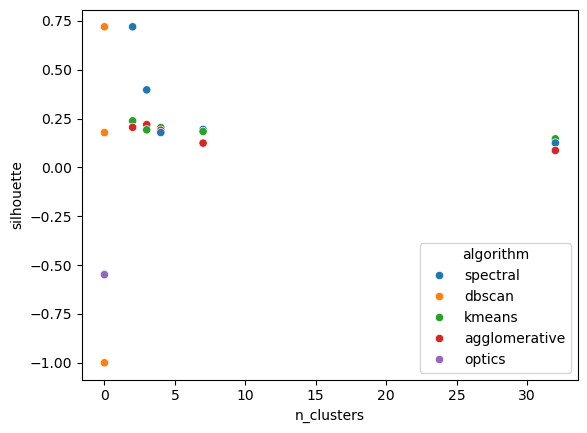

In [6]:
import seaborn


seaborn.scatterplot(
    results_df,
    x="n_clusters",
    y="silhouette",
    hue="algorithm"
)

## How do clusters relate with original data?

In [7]:
reference_clustering_index = 19
reference_clustering = clusterings[reference_clustering_index]
clustering_dataframe = pd.DataFrame(reference_clustering, columns=["clustering"])
dataset_with_clustering = pd.concat((cyclists, clustering_dataframe), axis="columns")

# for simplicity, only show a subset of the data
dataset_with_clustering = dataset_with_clustering.iloc[:reference_clustering.size, :]

dataset_with_clustering = dataset_with_clustering.astype({"clustering": int})
dataset_with_clustering.head()

,_url,name,birth_year,weight,height,nationality,bmi,career_points,career_duration(days),career_duration(races),debut_year,avg_pos,clustering
0,bruno-surra,Bruno Surra,1964,73.0,185,Italy,21.329438,80.0,1.0,1.0,1989.0,110.000000,1
1,gerard-rue,Gérard Rué,1965,74.0,182,France,22.340297,26105.0,3492.0,222.0,1988.0,63.545045,0
2,jan-maas,Jan Maas,1996,69.0,189,Netherlands,19.316369,4425.0,519.0,49.0,2022.0,87.693878,1
3,nathan-van-hooydonck,Nathan Van Nathan Van Hooydonck,1995,78.0,192,Belgium,21.158854,17205.0,1982.0,161.0,2018.0,83.242236,1
4,jose-felix-parra,José Félix Parra,1997,55.0,171,Spain,18.809206,3085.0,721.0,48.0,2021.0,68.000000,1


In [8]:
clusters_sizes = np.unique(reference_clustering, return_counts=True)[1]
average_cyclist_per_cluster = dataset_with_clustering.groupby("clustering")\
    .describe()\
    .xs(                  # select from a multi-index dataframe
        "mean",           # which columns to select?
        level=1,          # at what level of the index?
        drop_level=True,  
        axis="columns"
    )
average_cyclist_per_cluster.loc[:, "cluster_size"] = clusters_sizes
std_cyclist_per_cluster = dataset_with_clustering.groupby("clustering")\
    .describe()\
    .xs(                  # select from a multi-index dataframe
        "std",           # which columns to select?
        level=1,          # at what level of the index?
        drop_level=True,  
        axis="columns"
    )
std_cyclist_per_cluster.loc[:, "cluster_size"] = clusters_sizes


average_cyclist_per_cluster


,birth_year,weight,height,bmi,career_points,career_duration(days),career_duration(races),debut_year,avg_pos,cluster_size
clustering,,,,,,,,,,
0,1974.368987,68.301689,179.476970,21.189765,21796.387123,3519.604913,244.740532,1997.840839,73.353831,1954
1,1980.970521,68.644677,179.815264,21.208400,2663.986920,711.281035,31.364232,2005.693089,93.829681,3053
2,1979.974359,67.564103,179.333333,20.986503,0.000000,0.000000,0.000000,0.000000,-1.000000,39
3,1953.877757,69.054320,180.342831,21.228965,1751.311780,851.655331,14.602022,1979.103860,32.735370,1088


In [9]:
std_cyclist_per_cluster

,birth_year,weight,height,bmi,career_points,career_duration(days),career_duration(races),debut_year,avg_pos,cluster_size
clustering,,,,,,,,,,
0,11.566034,5.775006,5.933384,1.284191,14175.057750,1217.940407,163.855980,11.401519,20.929506,1954
1,13.256312,6.408694,6.275663,1.392374,3179.347298,773.297904,38.143547,12.656846,27.488516,3053
2,11.741710,6.340326,5.521886,1.445792,0.000000,0.000000,0.000000,0.000000,0.000000,39
3,8.872746,5.678038,6.533131,1.334135,3066.079464,1078.507091,26.329221,8.392908,21.704186,1088


## What features are relevant to clustering

In [10]:
average_cyclist_per_cluster.std().sort_values()

bmi                           0.112416
height                        0.448559
weight                        0.631422
birth_year                   12.619211
avg_pos                      42.289548
career_duration(races)      115.422778
debut_year                  997.168683
cluster_size               1280.325610
career_duration(days)      1544.970312
career_points             10222.251749
dtype: float64

## Clustering Preprocessing

In [11]:
cyclists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   _url                    6134 non-null   object 
 1   name                    6134 non-null   object 
 2   birth_year              6134 non-null   int64  
 3   weight                  6134 non-null   float64
 4   height                  6134 non-null   int64  
 5   nationality             6134 non-null   object 
 6   bmi                     6134 non-null   float64
 7   career_points           6134 non-null   float64
 8   career_duration(days)   6134 non-null   float64
 9   career_duration(races)  6134 non-null   float64
 10  debut_year              6134 non-null   float64
 11  avg_pos                 6134 non-null   float64
dtypes: float64(7), int64(2), object(3)
memory usage: 575.2+ KB


In [12]:
# since several algorithms are randomized, we set a seed to repeat them
RANDOM_STATE = 42

# load dataset
datasetname = path.join('..','dataset', 'cyclists_final_enhanced.csv')
cyclists = pd.read_csv(datasetname)
num_columns = ['bmi', 'height', 'weight', 'birth_year', 'avg_pos', 'career_duration(races)', 'debut_year', 'career_duration(days)', 'career_points']
cat_columns = ['nationality']
df = cyclists.copy()
numeric_dataset = df[num_columns]
cat_dataset = df[cat_columns]

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
scaler.fit(numeric_dataset)
X = scaler.transform(numeric_dataset)

In [14]:
pd.DataFrame(scaler.inverse_transform(scaler.transform(numeric_dataset)), columns=numeric_dataset.columns)

,bmi,height,weight,birth_year,avg_pos,career_duration(races),debut_year,career_duration(days),career_points
0,21.329438,185.0,73.0,1964.0,110.000000,1.0,1989.0,1.0,80.0
1,22.340297,182.0,74.0,1965.0,63.545045,222.0,1988.0,3492.0,26105.0
2,19.316369,189.0,69.0,1996.0,87.693878,49.0,2022.0,519.0,4425.0
3,21.158854,192.0,78.0,1995.0,83.242236,161.0,2018.0,1982.0,17205.0
4,18.809206,171.0,55.0,1997.0,68.000000,48.0,2021.0,721.0,3085.0
...,...,...,...,...,...,...,...,...,...
6129,19.350208,179.0,62.0,1966.0,10.000000,1.0,1993.0,1.0,80.0
6130,21.220009,188.0,75.0,1998.0,84.576923,26.0,2020.0,1140.0,2410.0
6131,20.451146,181.0,67.0,1973.0,106.500000,12.0,1997.0,311.0,955.0
6132,20.069204,170.0,58.0,1985.0,71.929204,113.0,2009.0,1849.0,8920.0


In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [16]:
kmeans = KMeans(n_clusters=5, n_init=10, max_iter=100)
kmeans.fit(X)

KMeans(max_iter=100, n_clusters=5, n_init=10)

In [17]:
kmeans.labels_[:5]

array([0, 3, 0, 0, 1], dtype=int32)

In [18]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32), array([1793, 1793, 1499, 1010,   39]))

<Axes: xlabel='height', ylabel='weight'>

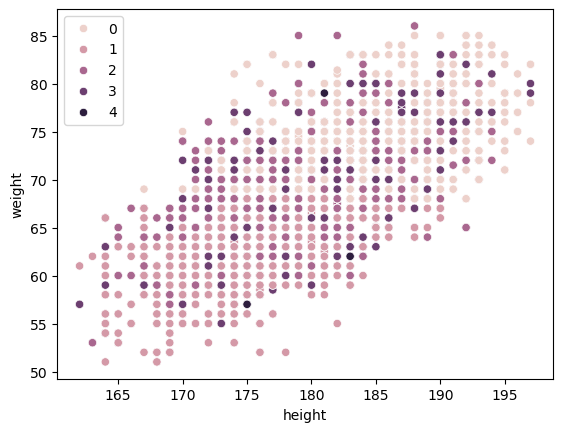

In [19]:
seaborn.scatterplot(data=numeric_dataset, x="height", y="weight", hue=kmeans.labels_)

In [20]:
kmeans.cluster_centers_

array([[ 4.75330173e-01,  6.80434159e-01,  8.72435647e-01,
         4.44745854e-01,  5.76594633e-01, -3.10054357e-01,
         1.23704722e-01, -2.51892796e-01, -3.17733247e-01],
       [-6.07094897e-01, -6.18597352e-01, -9.07105120e-01,
         4.41650633e-01,  4.83072557e-01, -3.18093906e-01,
         1.23882919e-01, -3.70711403e-01, -3.48920462e-01],
       [ 1.60944128e-01, -5.50172329e-02,  6.03486859e-02,
        -1.19485855e+00, -1.10433368e+00, -5.04364808e-01,
        -3.28712820e-02, -3.24588459e-01, -4.64438953e-01],
       [-6.51600295e-05, -2.63793239e-02, -2.32773347e-02,
         1.86940227e-01, -1.51630834e-01,  1.88809429e+00,
         9.00189816e-02,  1.62351570e+00,  1.89749700e+00],
       [-1.61803967e-01, -7.47498698e-02, -1.70294598e-01,
         3.81170766e-01, -2.28763696e+00, -6.84165819e-01,
        -1.24456190e+01, -9.97532742e-01, -6.94840343e-01]])

In [21]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)

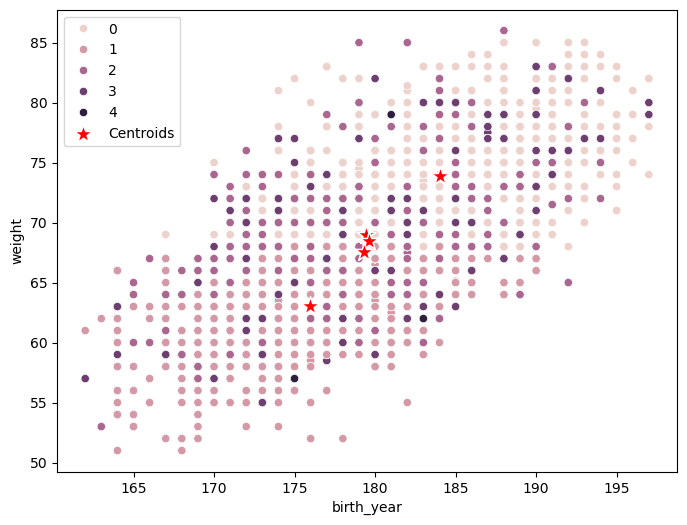

In [ ]:
import matplotlib.pyplot as plt
# Create a single plot
plt.figure(figsize=(8, 6))

# Second scatter plot: for the numeric_dataset with KMeans labels
seaborn.scatterplot(data=numeric_dataset, x="height", y="weight", hue=kmeans.labels_)

# Plot the NumPy data with a different marker style
seaborn.scatterplot(x=centers[:,1], y=centers[:, 2], label='Centroids', s=200, marker='*', c='r')


# Add labels and title
plt.xlabel('height')
plt.ylabel('weight')

# Display the plot
plt.legend()
plt.show()

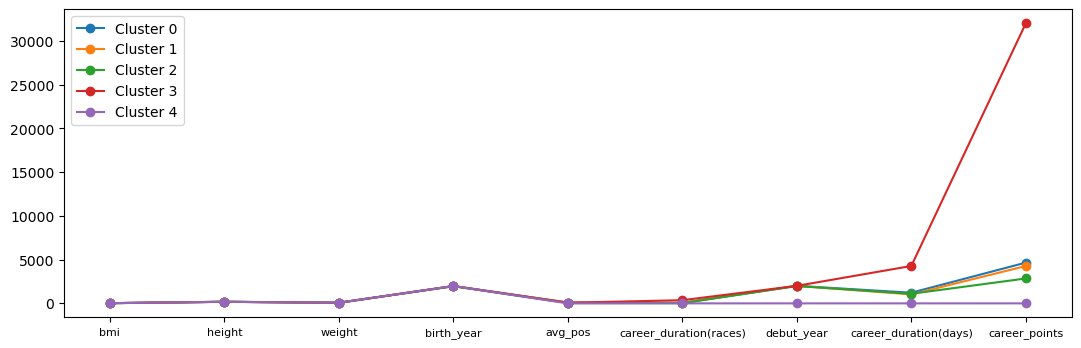

In [23]:
plt.figure(figsize=(13, 4))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(range(0, len(numeric_dataset.columns)), numeric_dataset.columns, fontsize=8)
plt.legend(fontsize=10)
plt.show()

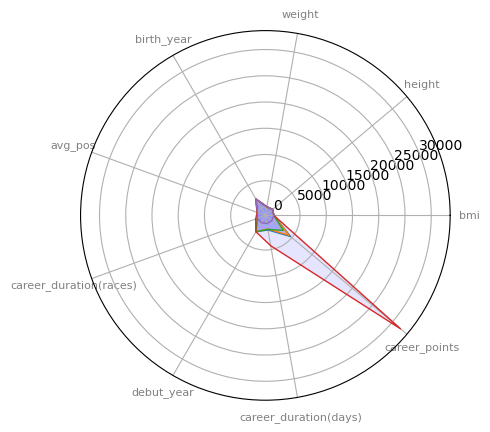

In [24]:
from math import pi
 
# number of variable
N = len(numeric_dataset.columns)
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
for i in range(0, len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]
# Initialise the spider plot
    ax = plt.subplot(polar=True)
# Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], numeric_dataset.columns, color='grey', size=8) 
# Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')
 # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)

In [25]:
from sklearn import metrics

print('SSE %s' % kmeans.inertia_) # cohesion, lower value better clustering (error minimization)
print('Separation %s' % metrics.davies_bouldin_score(X, kmeans.labels_)) # lower value, better clustering (minimum zero)
print('Silhouette %s' % silhouette_score(X, kmeans.labels_))
# Silhouette. The best value is 1 and the worst value is -1. 
# Values near 0 indicate overlapping clusters. 
# Negative values generally indicate that a sample has been assigned to the wrong cluster

SSE 25710.889953336096
Separation 1.1688380208729263
Silhouette 0.21690617784066268


In [26]:
cross_df = pd.crosstab(kmeans.labels_,df['nationality'])
cross_df

nationality,Albania,Algeria,Argentina,Australia,Austria,Azerbaijan,Belarus,Belgium,Brazil,Bulgaria,Canada,Chile,China,Colombia,Costa Rica,Croatia,Czech Republic,Denmark,Dominican Republic,Ecuador,Eritrea,Estonia,Ethiopia,Finland,France,Germany,Great Britain,Greece,Guatemala,Hongkong,Hungary,Iran,Ireland,Israel,Italy,Japan,Kazakhstan,Latvia,Liechtenstein,Lithuania,Luxembourg,Mexico,Moldova,Monaco,Morocco,Namibia,Netherlands,New Zealand,Norway,Panama,Poland,Portugal,Puerto Rico,Romania,Russia,Rwanda,Serbia,Slovakia,Slovenia,South Africa,Spain,Sweden,Switzerland,Taiwan,Tunisia,Ukraine,United States,Uruguay,Uzbekistan,Venezuela,Yugoslavia,Zimbabwe
row_0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,2,5,54,15,0,4,239,4,3,23,0,2,46,1,5,17,43,0,0,3,15,1,4,186,80,35,1,0,0,2,2,7,2,282,3,12,9,0,13,8,1,0,0,0,1,115,17,30,0,31,35,0,2,49,0,4,8,12,9,207,13,60,1,1,17,46,1,0,3,0,1
1,0,0,3,32,15,1,3,157,10,4,15,2,2,105,0,2,13,33,1,4,3,2,2,3,192,51,30,0,1,1,6,1,8,4,321,13,17,2,0,8,3,3,2,1,3,0,61,6,13,2,29,68,1,2,38,1,0,5,12,11,309,7,63,0,0,14,54,2,4,11,1,0
2,0,0,1,12,10,0,1,360,1,0,2,0,0,29,0,0,5,13,0,0,0,0,0,0,206,48,32,0,1,0,0,0,1,0,239,2,0,1,1,1,5,0,0,0,0,0,138,4,11,0,17,23,0,0,19,0,0,0,1,2,208,14,71,0,0,4,14,0,0,2,0,0
3,0,0,2,35,12,0,4,99,1,0,7,0,0,15,1,2,5,20,0,1,2,3,1,2,152,42,19,0,0,0,0,0,7,0,182,2,11,3,0,2,7,1,1,0,0,0,65,5,7,0,14,8,0,0,20,0,0,3,13,4,146,5,39,0,0,7,31,0,1,1,0,0
4,0,0,0,0,1,0,0,14,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,5,1,0,0,0,0,0,0,0,0,5,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,2,0,0,1,0,0,2,0,1,0,0,0,1,0,0,0,0,0


In [27]:
sse_list = list()
max_k = 40
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X)
    
    sse = kmeans.inertia_
    sse_list.append(sse)

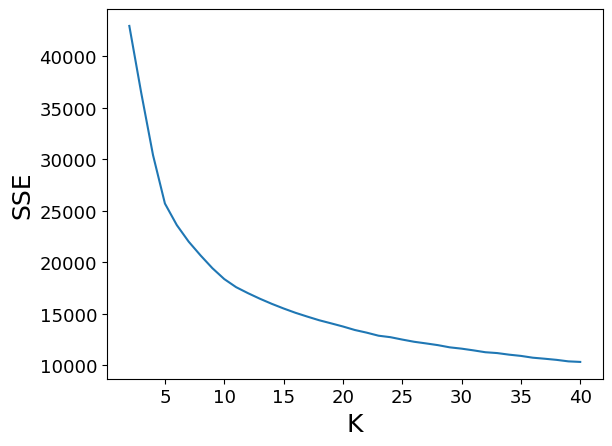

In [28]:
plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE', fontsize=18)
plt.xlabel('K', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.show()